In [129]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import NASNetMobile, MobileNetV2, InceptionResNetV2, ResNet50, MobileNet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from functools import partial
from multiprocessing import Pool
from super_convergence.clr import OneCycleLR
from PIL import Image

import time
start = dt.datetime.now()

In [160]:
DP_DIR = ''
INPUT_DIR = ''

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, '../../data/train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [131]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [186]:
batchsize = 64
NUM_SAMPLES = 500000
STEPS = NUM_SAMPLES//batchsize 
EPOCHS = 100
size = 128



In [197]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
#model = NASNetMobile(input_shape=(size, size, 1),  weights=None, classes=NCATS)
#model = InceptionResNetV2(input_shape=(size, size, 1),  weights=None, classes=NCATS)
#model = ResNet50(input_shape=(size, size, 1),  weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.00085), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [202]:
def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 
            #color = 255 
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def get_input(df, size, lw):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = preprocess_input(x).astype(np.float32)
    y = keras.utils.to_categorical(df.y, num_classes=NCATS)
    return x, y

    
def image_generator_xd(size, batchsize, ks, lw=6):
    partial_get_input = partial(get_input, size = size, lw=lw)
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'full_train/train_k{}.csv.gz'.format(k))
            for chunk in pd.read_csv(filename, chunksize=batchsize):
                yield partial_get_input(chunk)
# #             p = Pool(1)
#             batches = map(partial_get_input, chunks)
#             #batches = Parallel(n_jobs=-1)(delayed(partial_get_input)(chunk) for chunk in chunks)
#             for batch in batches:
#                 yield batch 
                
def df_to_image_array_xd(df, size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = preprocess_input(x).astype(np.float32)
    return x



In [192]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=30000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(30000, 128, 128, 1) (30000, 340)
Validation array memory 1.83 GB


In [193]:
#model.load_weights("model")

In [203]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

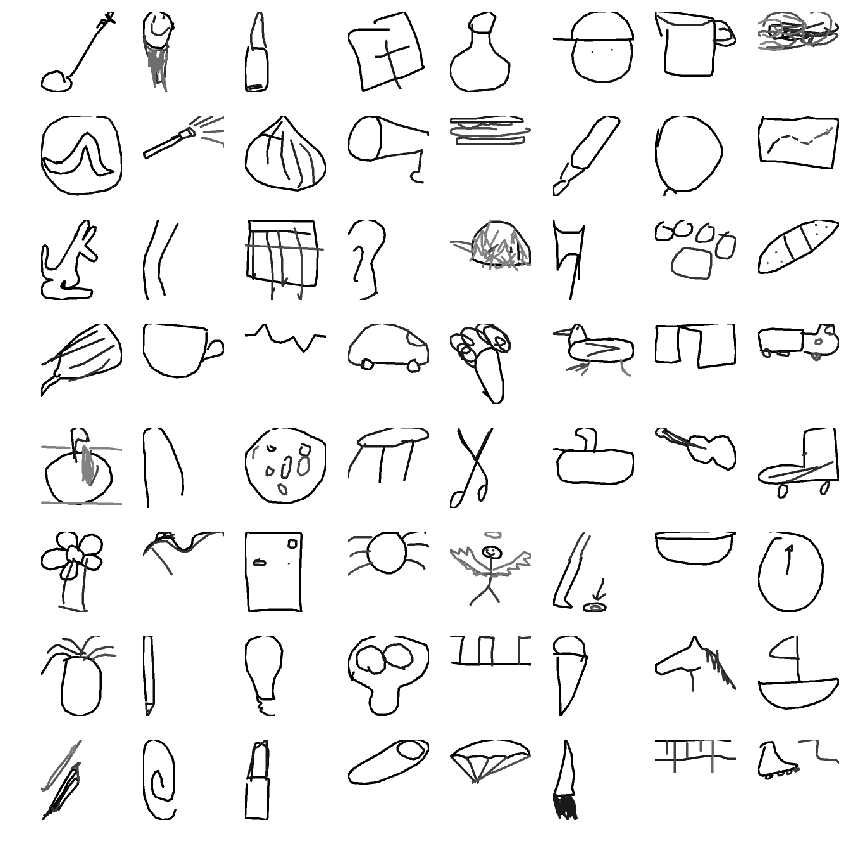

In [200]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [196]:
callbacks = [
    ModelCheckpoint(filepath='model', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
]

In [198]:
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
    use_multiprocessing=True
)
hists.append(hist)

Epoch 1/100
7811/7812 [============================>.] - ETA: 0s - loss: 2.1126 - categorical_crossentropy: 2.1126 - categorical_accuracy: 0.5054 - top_3_accuracy: 0.6989
Epoch 00001: val_loss improved from inf to 1.53397, saving model to model
7812/7812 [==============================] - 855s 109ms/step - loss: 2.1124 - categorical_crossentropy: 2.1124 - categorical_accuracy: 0.5055 - top_3_accuracy: 0.6990 - val_loss: 1.5340 - val_categorical_crossentropy: 1.5340 - val_categorical_accuracy: 0.6170 - val_top_3_accuracy: 0.8116
Epoch 2/100
7811/7812 [============================>.] - ETA: 0s - loss: 1.3675 - categorical_crossentropy: 1.3675 - categorical_accuracy: 0.6588 - top_3_accuracy: 0.8384
Epoch 00002: val_loss improved from 1.53397 to 1.51590, saving model to model
7812/7812 [==============================] - 722s 92ms/step - loss: 1.3675 - categorical_crossentropy: 1.3675 - categorical_accuracy: 0.6588 - top_3_accuracy: 0.8384 - val_loss: 1.5159 - val_categorical_crossentropy: 

KeyboardInterrupt: 

In [190]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/100
7811/7812 [============================>.] - ETA: 0s - loss: 0.8314 - categorical_crossentropy: 0.8314 - categorical_accuracy: 0.7865 - top_3_accuracy: 0.9167
Epoch 00001: val_loss improved from inf to 1.27269, saving model to model
7812/7812 [==============================] - 750s 96ms/step - loss: 0.8314 - categorical_crossentropy: 0.8314 - categorical_accuracy: 0.7865 - top_3_accuracy: 0.9167 - val_loss: 1.2727 - val_categorical_crossentropy: 1.2727 - val_categorical_accuracy: 0.6885 - val_top_3_accuracy: 0.8436
Epoch 2/100
7811/7812 [============================>.] - ETA: 0s - loss: 0.8321 - categorical_crossentropy: 0.8321 - categorical_accuracy: 0.7866 - top_3_accuracy: 0.9169
Epoch 00002: val_loss did not improve from 1.27269
7812/7812 [==============================] - 666s 85ms/step - loss: 0.8321 - categorical_crossentropy: 0.8321 - categorical_accuracy: 0.7866 - top_3_accuracy: 0.9169 - val_loss: 1.4840 - val_categorical_crossentropy: 1.4840 - val_categorical_acc

KeyboardInterrupt: 

In [204]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/100
7811/7812 [============================>.] - ETA: 0s - loss: 1.0132 - categorical_crossentropy: 1.0132 - categorical_accuracy: 0.7426 - top_3_accuracy: 0.8924
Epoch 00001: val_loss did not improve from 1.01430
7812/7812 [==============================] - 641s 82ms/step - loss: 1.0132 - categorical_crossentropy: 1.0132 - categorical_accuracy: 0.7426 - top_3_accuracy: 0.8924 - val_loss: 1.0240 - val_categorical_crossentropy: 1.0240 - val_categorical_accuracy: 0.7381 - val_top_3_accuracy: 0.8915
Epoch 2/100
7811/7812 [============================>.] - ETA: 0s - loss: 0.9964 - categorical_crossentropy: 0.9964 - categorical_accuracy: 0.7469 - top_3_accuracy: 0.8955
Epoch 00002: val_loss improved from 1.01430 to 0.95664, saving model to model
7812/7812 [==============================] - 638s 82ms/step - loss: 0.9964 - categorical_crossentropy: 0.9964 - categorical_accuracy: 0.7469 - top_3_accuracy: 0.8955 - val_loss: 0.9566 - val_categorical_crossentropy: 0.9566 - val_categorical

KeyboardInterrupt: 

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [19]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

3000/3000 [==============================] - 6s 2ms/step
Map3: 0.827


In [25]:
scores = [apk(actual, predicted) for actual,predicted in zip(valid_df[['y']].values, preds2catids(valid_predictions).values)]

In [28]:
valid_df['scores'] = scores

In [42]:
valid_df[valid_df['scores']==1]['recognized'].value_counts()

True     2225
False      69
Name: recognized, dtype: int64

In [50]:
valid_df['images'] = list(x_valid)

In [64]:
valid_df.head()



,countrycode,drawing,recognized,timestamp,word,y,cv,images
0,US,"[[[8, 1, 9], [0, 71, 1]], [[7, 243], [35, 46]]...",True,2017-03-19 20:07:44.354570,dumbbell,99,99,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [0.9..."
1,RU,"[[[23, 13, 5, 0, 17, 41, 52, 67, 41, 34, 28], ...",True,2017-01-07 09:14:04.648210,rhinoceros,239,99,"[[[0.9921875], [0.9921875], [0.9921875], [0.99..."
2,IN,"[[[75, 43], [112, 250]], [[116, 115, 125], [11...",True,2017-03-12 11:00:08.126240,windmill,333,99,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1...."
3,US,"[[[64, 59, 68, 77, 79, 77, 71], [113, 120, 130...",True,2017-04-01 23:06:59.605080,scorpion,249,99,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1...."
4,US,"[[[0, 2, 22, 31, 44, 49, 54, 64, 138, 143, 133...",True,2017-01-23 17:37:22.441430,dog,90,99,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1...."


In [76]:
img = valid_df.iloc[2]['images']

In [77]:
img

array([[[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       ...,

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]]], dtype=float32)

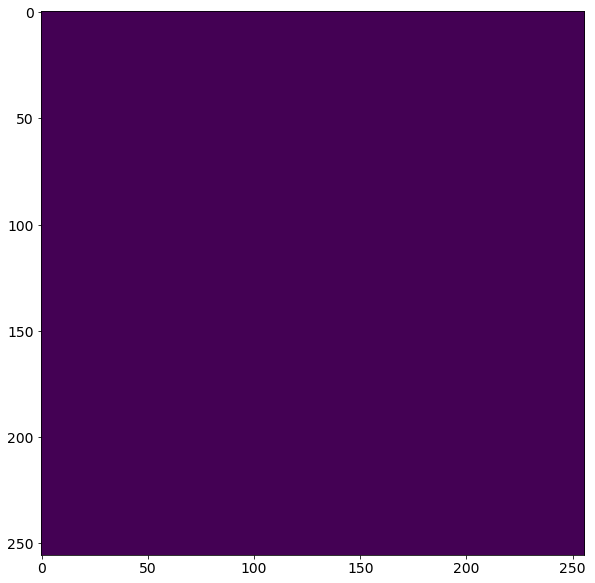

In [71]:
plt.imshow(img)

In [ ]:
test_predictions = [] 
for chunk in pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'), chunksize=1024):
    x_test = df_to_image_array_xd(chunk, size)
    predictions = list(model.predict(x_test, batch_size=128, verbose=1))
    test_predictions.extend(predictions)


In [ ]:

top3 = preds2catids(np.array(test_predictions))
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

In [ ]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{2}.csv', index=False)
submission.head()
submission.shape

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))